In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.utils.data as data
import seaborn as sns

# SciKit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time

### Load dataset & 看資料長啥樣

In [58]:
# load dataset
input_data = pd.read_csv('station/466920taipei_train.csv', usecols = ["觀測時間(hour)", "測站氣壓(hPa)", "海平面氣壓(hPa)", "氣溫(℃)", "露點溫度(℃)", "相對溼度(%)", "風速(m/s)", "降水量(mm)", "降水時數(hr)", "日照時數(hr)", "天全空日射量(MJ/㎡)"])
pred_data = pd.read_csv('station/466920taipei_test.csv')

# Normalization
scaler = MinMaxScaler(feature_range=(-1, 1))

# fill NaN with 0
input_data = input_data.fillna(0)

input_data['觀測時間(hour)'] = pd.to_datetime(input_data['觀測時間(hour)'])
input_data.set_index('觀測時間(hour)')

# input_data.head()
input_data.shape

(96360, 11)

### 看一年的資料長啥樣

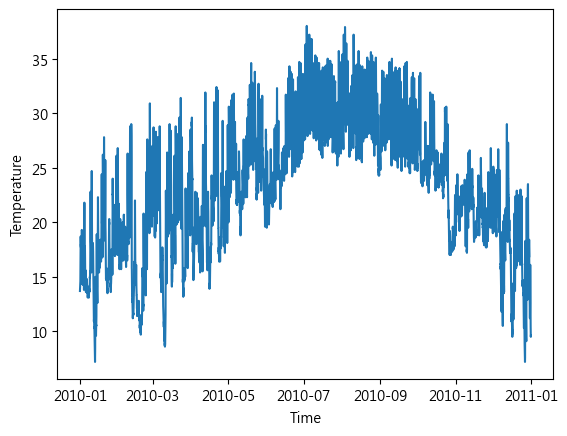

In [59]:
# 選擇 2010 年的資料
input_data_2010 = input_data[input_data['觀測時間(hour)'].dt.year == 2010]

plt.plot(input_data_2010['觀測時間(hour)'], input_data_2010['氣溫(℃)'])
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

# Feature Selection

### Random Forest

測站氣壓(hPa): 0.07918709173242941
海平面氣壓(hPa): 0.013878991884222291
露點溫度(℃): 0.6985835741766243
相對溼度(%): 0.19282553489200843
風速(m/s): 0.002887768537759049
降水量(mm): 0.0007641947341405708
降水時數(hr): 0.0009002823835793681
日照時數(hr): 0.010510744530780245
天全空日射量(MJ/㎡): 0.00046181712845636203
Top 5 features: Index(['露點溫度(℃)', '相對溼度(%)', '測站氣壓(hPa)', '海平面氣壓(hPa)', '日照時數(hr)'], dtype='object')


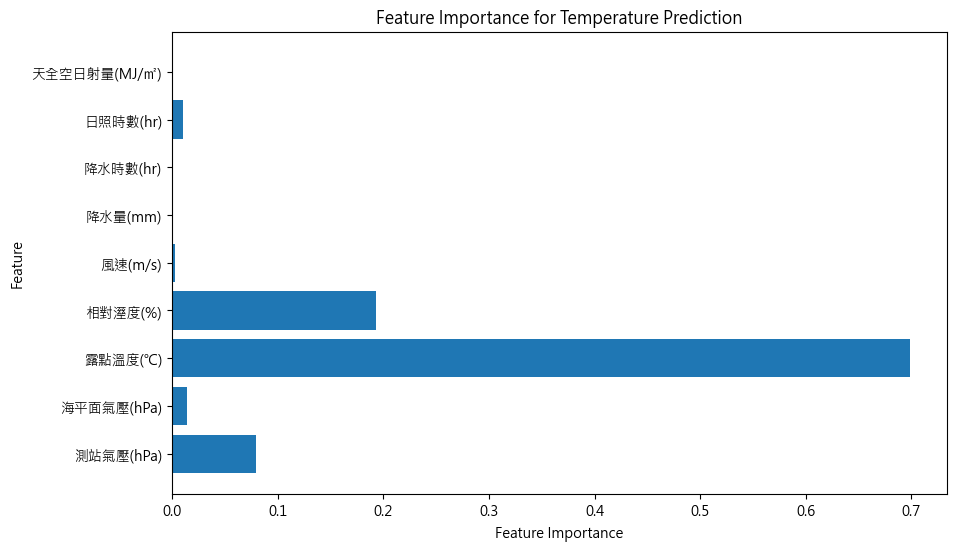

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# 分開特徵和目標變量
features = input_data.drop(columns=["氣溫(℃)", "觀測時間(hour)"])  # 丟棄不需要的特徵
labels = input_data["氣溫(℃)"]

# 切分 training dataset 和 validation dataset
train_feat, valid_feat, train_labels, valid_labels = train_test_split(features, labels, test_size=0.3, random_state=42)

# 構建Random Forest模型
rf = RandomForestRegressor()

# 訓練模型
rf.fit(train_feat, train_labels)

# 獲取特徵重要性
feature_importances = rf.feature_importances_

# 印出所有特徵的重要性數值
for i, feature in enumerate(features.columns):
    print(f"{feature}: {feature_importances[i]}")

# 找出前五個特徵的索引
top5_indices = feature_importances.argsort()[::-1][:5]

# 印出前五個特徵
top5_features = features.columns[top5_indices]
print("Top 5 features:", top5_features)

# 繪製特徵重要性長條圖
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 修改中文字體
plt.figure(figsize=(10, 6))
plt.barh(features.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Temperature Prediction')
plt.show()

In [61]:
# 取前三相關的特徵
train_feat = train_feat[["相對溼度(%)", "露點溫度(℃)", "測站氣壓(hPa)"]]
valid_feat = valid_feat[["相對溼度(%)", "露點溫度(℃)", "測站氣壓(hPa)"]]

## Dataset

In [62]:
orig_dataset = input_data["氣溫(℃)"].to_numpy()  # temperature

# store another normalized dataset
normalized_dataset = np.copy(orig_dataset)  
normalized_dataset = normalized_dataset.reshape(-1)

In [63]:
class TaipeiDataset(data.Dataset):
    def __init__(self, file):
        # read CSV
        # self.input_data = pd.read_csv(file, usecols = ["氣溫(℃)", "相對溼度(%)", "露點溫度(℃)", "測站氣壓(hPa)"])
        self.input_data = pd.read_csv(file, usecols = ["觀測時間(hour)", "氣溫(℃)"])
        self.orig_dataset = input_data["氣溫(℃)"].to_numpy()  # temperature

        # store another normalized dataset
        self.normalized_dataset = np.copy(self.orig_dataset)  
        self.normalized_dataset = self.normalized_dataset.reshape(-1, 1)  # (row, column): -1:不限;1:一(直)行

        # calculate normalization
        self.normalized_dataset = scaler.fit_transform(self.normalized_dataset)  # normalize氣溫至-1~1
        self.normalized_dataset = self.normalized_dataset.reshape(-1)  # 變成一維

        # use X history data (X months) generate one target 
        self.sample_len = 168  # 用前一星期預測未來1小時的氣溫

    def __len__(self):
        if len(self.orig_dataset) > self.sample_len:
            return len(self.orig_dataset) - self.sample_len
        else:
            return 0

    def __getitem__(self, index):
        # target is the last records
        target = np.array([self.orig_dataset[self.sample_len+index]]).astype(np.float64)  # 第X+1個月

        # data is the previous five records
        input = self.orig_dataset[index:(index+self.sample_len)]

        # LSTM requires time-series data to shape in this way
        input = input.reshape((-1, 1))
        
        # convert to PyTorch tensors
        input = torch.from_numpy(input)
        target = torch.from_numpy(target)
        
        return input, target

## DataLoader

In [64]:
# Load into Iterator (each time get one batch)

# Load dataset
dataset = TaipeiDataset('station/466920taipei_train.csv')

batch_size = 720

# Split training and validation set
train_len = int(0.7*len(dataset))
valid_len = len(dataset) - train_len
TrainData, ValidationData = random_split(dataset,[train_len, valid_len])

print('train_len: %d' %train_len)
print('valid_len: %d' %valid_len)

# Load into Iterator (each time get one batch)
train_loader = data.DataLoader(TrainData, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = data.DataLoader(ValidationData, batch_size=batch_size, shuffle=True, num_workers=0)

train_len: 67334
valid_len: 28858


In [65]:
# debug

print(next(iter(train_loader)))

[tensor([[[29.3000],
         [29.1000],
         [28.9000],
         ...,
         [30.5000],
         [30.4000],
         [29.7000]],

        [[23.2000],
         [23.4000],
         [23.3000],
         ...,
         [29.2000],
         [31.0000],
         [32.7000]],

        [[34.2000],
         [36.1000],
         [37.2000],
         ...,
         [29.4000],
         [30.7000],
         [32.0000]],

        ...,

        [[26.3000],
         [26.1000],
         [26.0000],
         ...,
         [27.8000],
         [27.9000],
         [27.7000]],

        [[22.7000],
         [22.7000],
         [22.2000],
         ...,
         [21.4000],
         [21.6000],
         [21.3000]],

        [[26.8000],
         [26.8000],
         [27.1000],
         ...,
         [31.5000],
         [31.4000],
         [29.9000]]], dtype=torch.float64), tensor([[29.1000],
        [33.2000],
        [33.8000],
        [27.4000],
        [28.4000],
        [28.2000],
        [25.7000],
        [30.60

## Model

In [66]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()

        self.n_features = 1
        self.hidden_size = 100
        num_layers = 1
        self.output_dim = 1

        self.lstm = nn.LSTM(input_size=self.n_features, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(self.hidden_size, self.output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take the output from the last time step
        out = self.linear(out)
        return out

model = LSTM()
model

c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM(
  (lstm): LSTM(1, 100, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

## Loss & Optimization

In [67]:
# Define loss function
criterion = nn.MSELoss()

# Define optimization strategy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training & Validation

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

train_loss_list = []
def train(model, train_loader, optimizer, criterion, device):
    model.train()

    train_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # Load the input features and labels from the training dataset
        data, target = data.float().to(device), target.float().to(device)
        
        # Reset the gradients to 0 for all learnable weight parameters
        optimizer.zero_grad()

        # Forward pass: Pass image data from training dataset, make predictions about class image belongs to (0-9 in this case)
        output = model(data)
        
        # Define our loss function, and compute the loss
        loss = criterion(output, target)
        # record training losses
        train_loss += loss.item()
        
        # Backward pass: compute the gradients of the loss w.r.t. the model's parameters
        loss.backward()
        
        # Update the neural network weights
        optimizer.step()

    # print completed result
    print('train_loss: %f' % (train_loss))
    train_loss_list.append(train_loss)
    return train_loss

test_loss_list = []
def test(model, test_loader, criterion, device):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for _, (data, target) in enumerate(test_loader):
            # Load the input features and labels from the test dataset
            data, target = data.float().to(device), target.float().to(device)
            
            # Make predictions: Pass image data from test dataset, make predictions about class image belongs to (0-9 in this case)
            output = model(data)
            
            # Compute the loss sum up batch loss
            test_loss += criterion(output, target).item()
            
            # Ensure that target is a 1D tensor
            target = target.view(-1)

            # Get the predicted class
            pred = output.round()

            # Compute the number of correct predictions
            correct += pred.eq(target).sum().item()
    
    # print completed result
    print('test_loss: %s' % (test_loss))
    print('correct: %s' % (correct))
    test_loss_list.append(test_loss)
    return test_loss

def predict(model, device, data):
    model.eval()     # Enter Evaluation Mode
    with torch.no_grad():
        pred = model(data)
        return pred

In [69]:
epoch = 50

# Running
for epoch in range(epoch):
    print("===== Epoch %i =====" % epoch)
    train(model, train_loader, optimizer, criterion, device)
    test(model, valid_loader, criterion, device)

===== Epoch 0 =====


train_loss: 32070.236618
test_loss: 6364.817962646484
correct: 38152
===== Epoch 1 =====
train_loss: 8258.982193
test_loss: 1920.79931640625
correct: 97284
===== Epoch 2 =====
train_loss: 2734.233410
test_loss: 722.3727741241455
correct: 99040
===== Epoch 3 =====
train_loss: 1120.659392
test_loss: 332.7352614402771
correct: 108256
===== Epoch 4 =====
train_loss: 567.074744
test_loss: 191.99869084358215
correct: 109783
===== Epoch 5 =====
train_loss: 343.166652
test_loss: 123.86111617088318
correct: 104923
===== Epoch 6 =====
train_loss: 236.328577
test_loss: 92.7587810754776
correct: 103604
===== Epoch 7 =====
train_loss: 174.630474
test_loss: 69.35682237148285
correct: 101560
===== Epoch 8 =====
train_loss: 135.337590
test_loss: 53.90416920185089
correct: 100260
===== Epoch 9 =====
train_loss: 108.900099
test_loss: 45.06173527240753
correct: 100094
===== Epoch 10 =====
train_loss: 90.683429
test_loss: 37.91242599487305
correct: 99423
===== Epoch 11 =====
train_loss: 76.996627
test_los

## 看loss

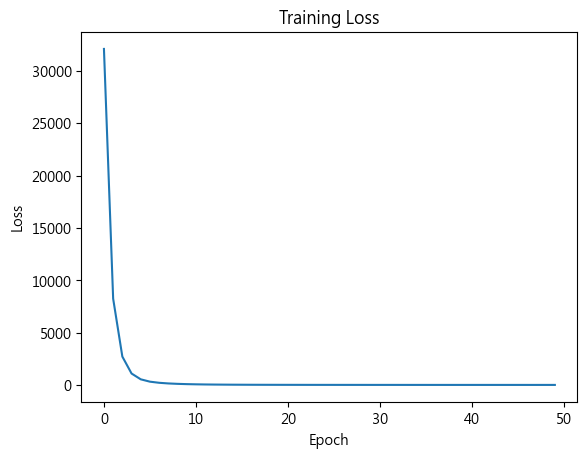

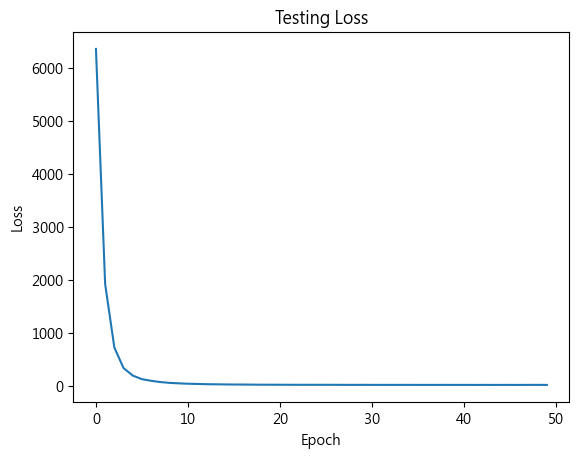

In [70]:
import matplotlib.pyplot as plt

def plot_train_loss(train_loss_list):
    plt.figure()
    plt.plot(range(len(train_loss_list)), train_loss_list)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def plot_test_loss(test_loss_list):
    plt.figure()
    plt.plot(range(len(test_loss_list)), test_loss_list)
    plt.title('Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

plot_train_loss(train_loss_list)
plot_test_loss(test_loss_list)

## Predict

In [71]:
# Predicting N months
N = 168  # 預測未來7天的氣溫

# 要預測的dataset
# pred_dataset = TaipeiDataset('station/466920taipei_test.csv')

# Extract the second column
# pred_temperature = pred_dataset["氣溫(℃)"]
pred_temperature = input_data["氣溫(℃)"]

# Pick P points randomly in data as starting
P = 10  # 10組prediction
points = np.random.randint(dataset.sample_len, high=len(dataset), size=P)  # 隨機抓每一組的預測起始點
preds = np.zeros((P, N))

# Forcast temperature for N hours
for idx_i, i in enumerate(points):
    normalized_temp, target = dataset[i]
    temperatures = normalized_temp.float()
    temperatures = temperatures.to(device)
    
    for idx_j, j in enumerate(range(N)):
        
        ii = temperatures.view(1, dataset.sample_len+idx_j, 1).float().to(device)   # transform into (batch, sequence, features)
        model = model.to(device)
        pred = predict(model, device, ii).float().to(device)
        preds[idx_i][idx_j] = pred

        # remove first temp and append predicted data at last
        # temperatures = torch.cat((temperatures[1:], pred.view(-1)))
        temperatures = torch.cat((temperatures, pred))
    
    # Inverse transform the predictions
    actual_predictions = scaler.inverse_transform(preds[idx_i].reshape(-1, 1))  # 從normalization轉為原始氣溫值  
    preds[idx_i] = actual_predictions.reshape(-1)

Predicted months:  range(9950, 10118)
Predicted months:  range(4670, 4838)
Predicted months:  range(9864, 10032)
Predicted months:  range(37064, 37232)
Predicted months:  range(62771, 62939)
Predicted months:  range(14705, 14873)
Predicted months:  range(87984, 88152)
Predicted months:  range(51793, 51961)
Predicted months:  range(49748, 49916)
Predicted months:  range(14021, 14189)


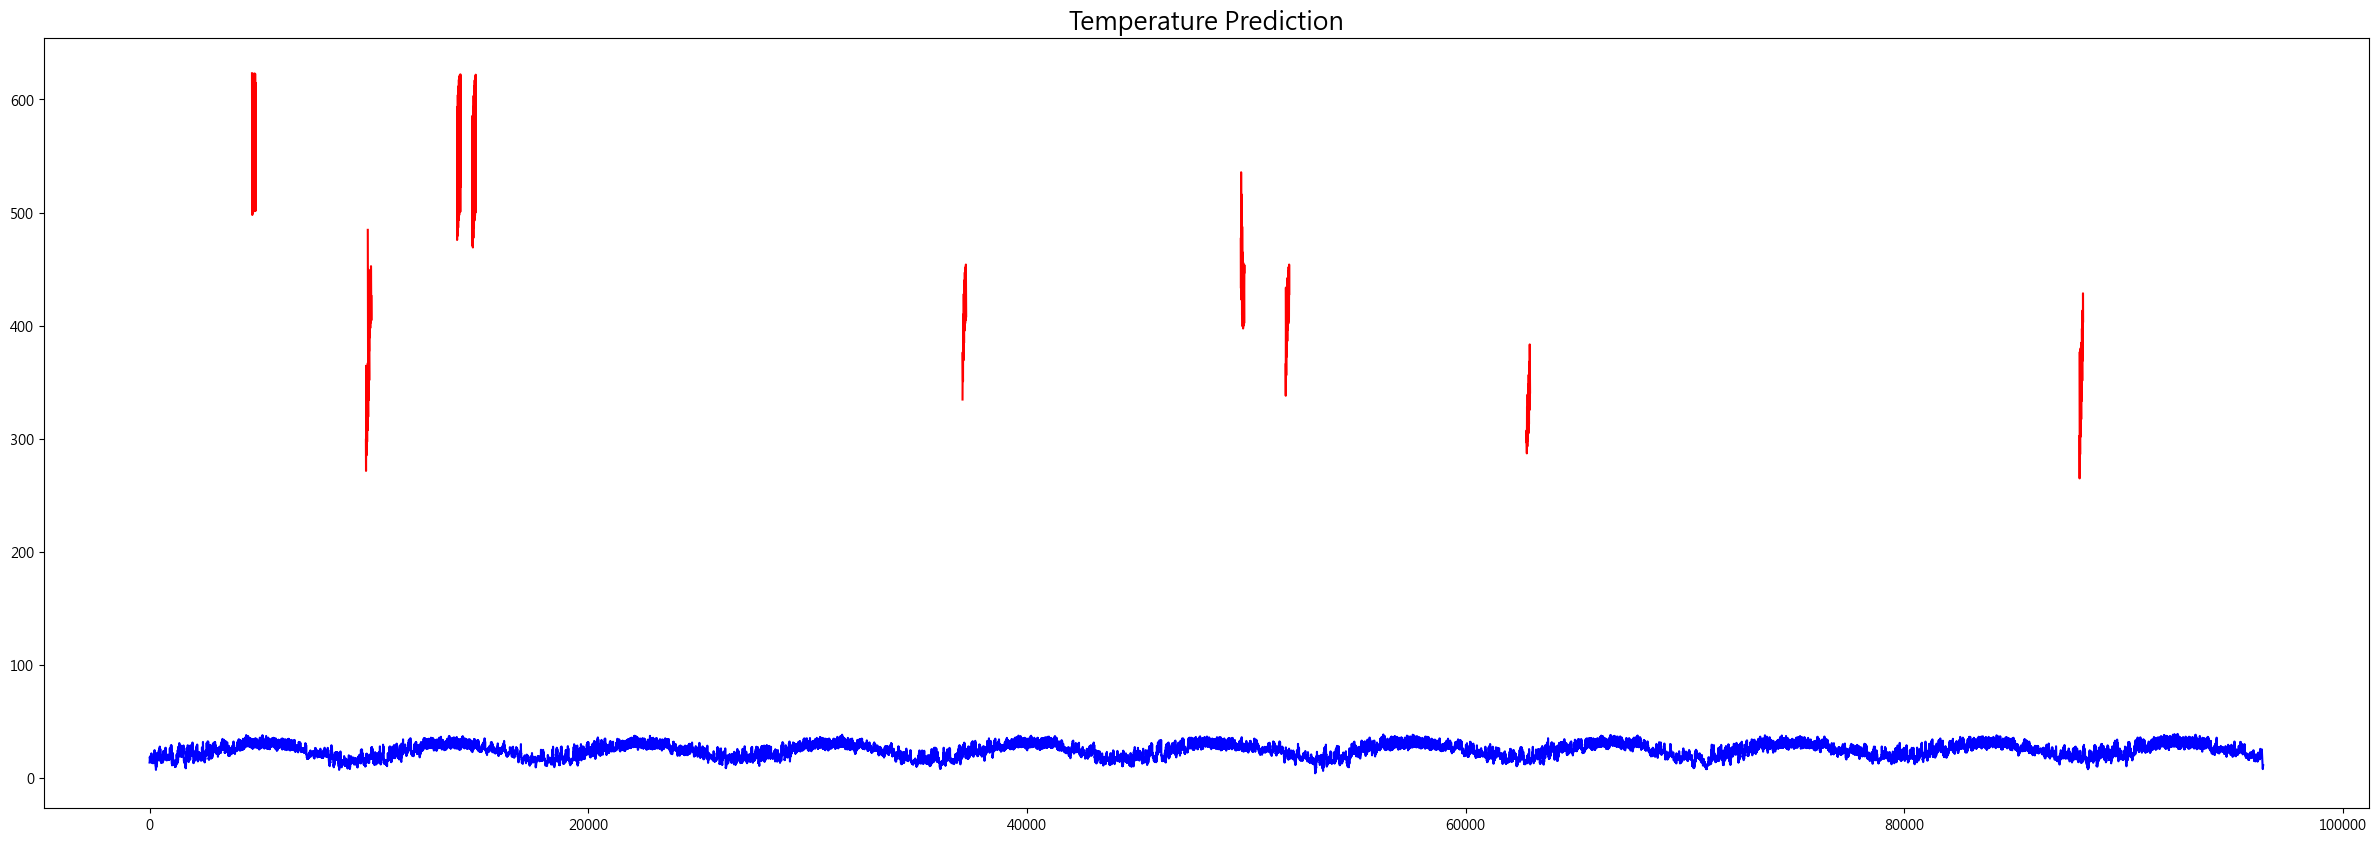

In [72]:
# Data
months = range(0, pred_temperature.size)

# Draw Inline
%matplotlib inline

# Draw Original Lines
plt.figure(figsize = (30,10))
plt.title('Temperature Prediction', fontsize=18)
plt.plot(months, pred_temperature, color='b')

# Draw all predicted points
for idx_i, i in enumerate(points):
    i_months = range(i, i+N)
    i_temps = preds[idx_i]
    plt.plot(i_months, i_temps, color='r')
    print("Predicted months: ", i_months)